# Тренировка модели + визуализация

In [1]:
%load_ext autoreload
%autoreload 2

# необходимые библиотеки и файлы
import os
import sys
sys.path.insert(0, "/home/m_evgeniy/BOSK")

from bosk.imports import *
from bosk.utils import load_model, visualize_losses_and_scores, make_prediction, predict_for_one_image, load_model_for_large_image
from bosk.__init__ import *

In [2]:
from pathlib import Path

# Setup path to data folder
data_path = Path("../data/Dataset_DeepGlobe/")

if data_path.is_dir():
    print(f"{data_path} directory exists.")
else:
    print(f"Did not find {data_path} directory :(")

../data/Dataset_DeepGlobe directory exists.


In [3]:
train_dir = data_path / "train"
val_dir = data_path / "valid"
test_dir = data_path / "test"

train_dir, val_dir, test_dir

(PosixPath('../data/Dataset_DeepGlobe/train'),
 PosixPath('../data/Dataset_DeepGlobe/valid'),
 PosixPath('../data/Dataset_DeepGlobe/test'))

In [4]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


walk_through_dir(data_path)

There are 3 directories and 0 images in '../data/Dataset_DeepGlobe'.
There are 2 directories and 0 images in '../data/Dataset_DeepGlobe/test'.
There are 0 directories and 1245 images in '../data/Dataset_DeepGlobe/test/masks'.
There are 0 directories and 1245 images in '../data/Dataset_DeepGlobe/test/images'.
There are 2 directories and 0 images in '../data/Dataset_DeepGlobe/valid'.
There are 0 directories and 622 images in '../data/Dataset_DeepGlobe/valid/masks'.
There are 0 directories and 622 images in '../data/Dataset_DeepGlobe/valid/images'.
There are 2 directories and 0 images in '../data/Dataset_DeepGlobe/train'.
There are 0 directories and 4359 images in '../data/Dataset_DeepGlobe/train/masks'.
There are 0 directories and 4359 images in '../data/Dataset_DeepGlobe/train/images'.


In [5]:
num_classes = 2
transform = None
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=num_classes,  # Меняем количество выходных классов
    ignore_mismatched_sizes=True  # Позволяет менять последний слой
).to(DEVICE)

model.decode_head.classifier = nn.Conv2d(256, 1, kernel_size=1)
torch.nn.init.xavier_uniform_(model.decode_head.classifier.weight)
torch.nn.init.zeros_(model.decode_head.classifier.bias)

model_type = "segformer"

/home/m_evgeniy/BOSK/venv/lib/python3.12/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
from torch.utils.data import Dataset

class DeepGlobeDataset(Dataset):
    def __init__(self, root_dir, model_type, transforms=None, processor=None, image_size=512):
        self.model_type = model_type
        self.transforms = transforms
        self.processor = processor
        self.image_size = image_size
        
        images_dir = root_dir / "images"
        masks_dir = root_dir / "masks"

        self.image_paths = sorted([
            images_dir / file_name for file_name in os.listdir(images_dir)
        ])
        self.mask_paths = sorted([
            masks_dir / file_name for file_name in os.listdir(masks_dir)
        ])
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        mask_path = self.mask_paths[index]
        
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.model_type == "segformer":
            encoding = self.processor(image, return_tensors="pt")
            image = encoding["pixel_values"].squeeze(0)  # [3, H, W]
            mask = mask.resize((self.image_size, self.image_size), resample=Image.NEAREST)
        else:
            image = self.transform(image)
            mask = mask.resize((self.image_size, self.image_size), resample=Image.NEAREST)

        mask = torch.tensor(np.array(mask), dtype=torch.long)
        mask[mask == 255] = 1

        return image, mask

In [7]:
train_data = DeepGlobeDataset(train_dir, model_type, transform, processor)

val_data = DeepGlobeDataset(val_dir, model_type, transform, processor)

test_data = DeepGlobeDataset(test_dir, model_type, transform, processor)

In [8]:
from torch.utils.data import DataLoader

batch_size = 8
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size, # how many samples per batch?
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_data,
                             batch_size=batch_size,
                             shuffle=False)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             shuffle=False)

len(train_dataloader), len(test_dataloader)

(545, 156)

In [9]:
next(iter(test_dataloader))[0].shape, next(iter(test_dataloader))[1].shape

(torch.Size([8, 3, 512, 512]), torch.Size([8, 512, 512]))

In [10]:
mask_array = next(iter(val_dataloader))[1][0]

# Определяем уникальные классы
unique_classes = np.unique(mask_array)
print("Уникальные классы в маске:", unique_classes)
print("Количество классов:", len(unique_classes))

Уникальные классы в маске: [0 1]
Количество классов: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..1.6495419].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.3088455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7925336..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3815396..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].


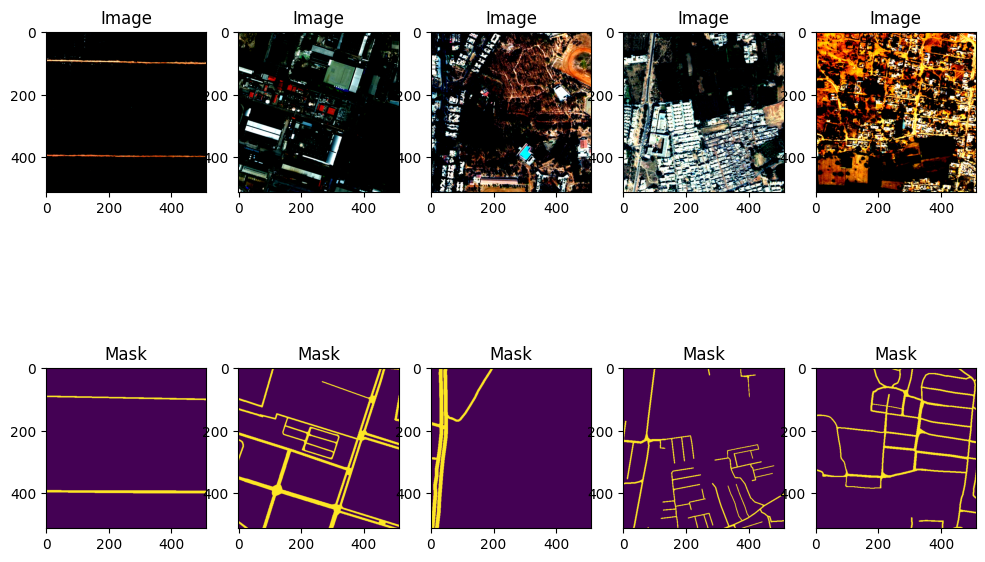

In [11]:
data = next(iter(test_dataloader))
num_examples = 5

fig, axes = plt.subplots(2, num_examples, figsize=(12, 8))

images, masks = data
for i in range(num_examples):
    axes[0, i].imshow(images[i].permute(1, 2, 0))
    axes[0, i].set_title("Image")
    axes[1, i].imshow(masks[i])
    axes[1, i].set_title("Mask")


In [12]:
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 512, 512),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                                     Input Shape          Output Shape         Param #              Trainable
SegformerForSemanticSegmentation (SegformerForSemanticSegmentation)         [1, 3, 512, 512]     [1, 1, 128, 128]     --                   True
├─SegformerModel (segformer)                                                [1, 3, 512, 512]     [1, 32, 128, 128]    --                   True
│    └─SegformerEncoder (encoder)                                           [1, 3, 512, 512]     [1, 32, 128, 128]    --                   True
│    │    └─ModuleList (patch_embeddings)                                   --                   --                   (recursive)          True
│    │    └─ModuleList (block)                                              --                   --                   (recursive)          True
│    │    └─ModuleList (layer_norm)                                         --                   --                   (recursive)  

In [13]:
def train(model, train_dataloader, valid_dataloader, criterion, lr, epochs, model_name, num_classes=5, device=DEVICE, verbose=False, is_scheduler=False):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    iou_score = JaccardIndex(task="multiclass" if num_classes > 2 else "binary", num_classes=num_classes).to(device)
    # dice_score = Dice(num_classes=1, threshold=0.5, zero_division=1e-8, multiclass=False).to(device)
    
    if is_scheduler:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Получаем первый батч валидации (фиксируем его)
    val_data, val_true_mask = next(iter(valid_dataloader))
    val_data, val_true_mask = val_data.to(device), val_true_mask.to(device)

    best_model = None
    best_val_loss = float("inf")  # Инициализируем наихудшее значение лосса
    best_val_iou_score = 0
    # best_val_dice_score = 0

    loss_history       = {"train": [], "valid": []}
    iou_score_history  = {"train": [], "valid": []}
    # dice_score_history = {"train": [], "valid": []}

    # Начальная проверка
    model.eval()
    with torch.no_grad():
        val_pred = make_prediction(model, val_data, model_name)
        initial_val_loss = criterion(val_pred.squeeze(1), val_true_mask.float()).item()
        initial_val_iou_score = iou_score(val_pred.squeeze(1), val_true_mask.squeeze(1)).detach()
        # initial_val_dice_score = dice_score(predicted_classes, val_true_mask.squeeze(1)).detach()

    print(f"Initial validation loss: {initial_val_loss:.4f}")
    print(f"Initial validation IoU score: {initial_val_iou_score:.4f}")
    # print(f"Initial validation Dice score: {initial_val_dice_score:.4f}")

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Обучение
        model.train()
        total_loss = 0
        total_iou_score, total_dice_score = 0, 0
        
        for data, true_mask in tqdm(train_dataloader, desc="Training", leave=False):
            data, true_mask = data.to(device), true_mask.to(device)
            optimizer.zero_grad()

            prediction = make_prediction(model, data, model_name)
            loss = criterion(prediction.squeeze(1), true_mask.float())

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_iou_score += iou_score(prediction.squeeze(1), true_mask.squeeze(1)).item()
            # total_dice_score += dice_score(prediction.squeeze(1), true_mask.squeeze(1)).item()

        train_loss = total_loss / len(train_dataloader)
        train_iou_score = total_iou_score / len(train_dataloader)
        # train_dice_score = total_dice_score / len(train_dataloader)

        if is_scheduler:
            scheduler.step()

        # Оценка на валидации
        torch.cuda.empty_cache()  # Очищаем кеш перед валидацией
        model.eval()
        with torch.no_grad():
            val_pred = make_prediction(model, val_data, model_name)

            val_loss = criterion(val_pred.squeeze(1), val_true_mask.float()).item()
            val_iou_score = iou_score(val_pred.squeeze(1), val_true_mask.squeeze(1)).detach()
            # val_dice_score = dice_score(predicted_classes, val_true_mask.squeeze(1)).detach()

        # Сохраняем лучшую модель
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_iou_score = val_iou_score
            # best_val_dice_score = val_dice_score
            best_model = deepcopy(model)

        # Логирование
        loss_history["train"].append(train_loss)
        loss_history["valid"].append(val_loss)
        iou_score_history["train"].append(train_iou_score)
        iou_score_history["valid"].append(val_iou_score)
        # dice_score_history["train"].append(train_dice_score)
        # dice_score_history["valid"].append(val_dice_score)

        if verbose:
            print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            print(f"Train IoU score: {train_iou_score:.4f}, Val IoU score: {val_iou_score:.4f}")
            # print(f"Train Dice score: {train_dice_score:.4f}, Val Dice score: {val_dice_score:.4f}")

    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Best Validation IoU score: {best_val_iou_score:.4f}")
    # print(f"Best Validation Dice score: {best_val_dice_score:.4f}")

    return best_model, loss_history, iou_score_history

In [17]:
lr = 1e-3
epochs = 5

model_save_name = "segformer_for_large_image_2"
assert model_save_name is not None, "Enter model's name for saving"

criterion = nn.BCEWithLogitsLoss()
best_model, loss_history, iou_score_history = train(model, train_dataloader, val_dataloader, criterion, lr, epochs, model_type, num_classes=num_classes, verbose=True)

torch.save(best_model.state_dict(), f"../models/{model_save_name}.pth")
print("Модель сохранена!")

Initial validation loss: 0.0577
Initial validation IoU score: 0.5978
Epoch 1/5


Training:   0%|          | 0/545 [00:00<?, ?it/s]

Train Loss: 0.0664, Val Loss: 0.0687
Train IoU score: 0.4887, Val IoU score: 0.5201
Epoch 2/5


Training:   0%|          | 0/545 [00:00<?, ?it/s]

Train Loss: 0.0628, Val Loss: 0.0596
Train IoU score: 0.5093, Val IoU score: 0.5755
Epoch 3/5


Training:   0%|          | 0/545 [00:00<?, ?it/s]

Train Loss: 0.0607, Val Loss: 0.0594
Train IoU score: 0.5238, Val IoU score: 0.5802
Epoch 4/5


Training:   0%|          | 0/545 [00:00<?, ?it/s]

Train Loss: 0.0586, Val Loss: 0.0604
Train IoU score: 0.5387, Val IoU score: 0.5848
Epoch 5/5


Training:   0%|          | 0/545 [00:00<?, ?it/s]

Train Loss: 0.0568, Val Loss: 0.0559
Train IoU score: 0.5487, Val IoU score: 0.6097
Best Validation Loss: 0.0559
Best Validation IoU score: 0.6097
Модель сохранена!


In [15]:
model_path = "../models/segformer_for_large_image_2.pth"
model = load_model_for_large_image(model_path).to(DEVICE)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


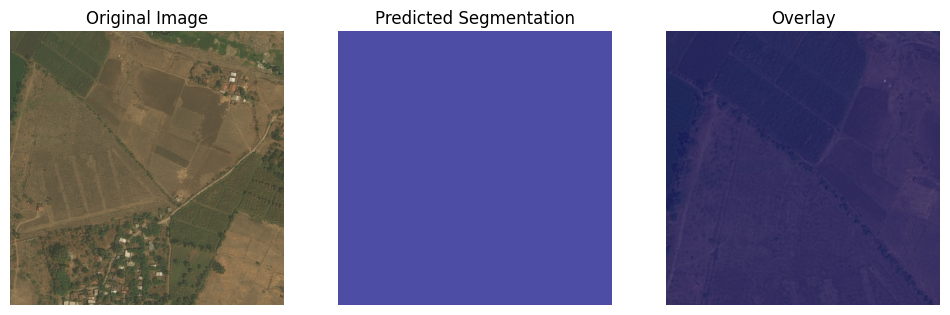

In [18]:
def predict_and_visualize(model, image_path, model_type, device=DEVICE):
    # Преобразования
    transform = T.Compose([
        T.Resize((512, 512)),
        T.ToTensor(),
    ])

    # Загружаем изображение
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Предсказание
    with torch.no_grad():
        output = make_prediction(model, input_tensor, model_type)
        predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # === Визуализация ===
    plt.figure(figsize=(12, 5))

    # Оригинальное изображение
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Original Image")

    # Предсказанная маска
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap="jet", alpha=0.7)
    plt.axis("off")
    plt.title("Predicted Segmentation")

    # Наложение маски на изображение
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(predicted_mask, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.title("Overlay")

    plt.show()


image_path = "../data/Dataset_DeepGlobe/train/images/3602_sat.jpg"
predict_and_visualize(best_model, image_path, model_type="segformer")